In [2]:
import numpy as np
import mne
from scipy.signal import butter, filtfilt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.preprocessing import StandardScaler
from typing import Union, Tuple, Optional
import torch
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
%matplotlib inline

In [3]:
from bci_aic3.config import (
    load_processing_config,
    load_model_config,
    load_training_config,
)
from bci_aic3.data import load_raw_data
from bci_aic3.paths import (
    LABEL_MAPPING_PATH,
    RAW_DATA_DIR,
    MI_CONFIG_PATH,
    SSVEP_CONFIG_PATH,
)
from bci_aic3.util import read_json_to_dict

label_mapping = read_json_to_dict(LABEL_MAPPING_PATH)


In [ ]:
train, val, test = load_raw_data(
    base_path=RAW_DATA_DIR, task_type="MI", label_mapping=label_mapping
)

100%|██████████| 50/50 [00:02<00:00, 19.51it/s]


In [ ]:
class MNENotchFilter(BaseEstimator, TransformerMixin):
    """Notch filter using MNE for EEG data."""

    def __init__(self, sfreq: float = 250.0, notch_freq: Union[float, list] = 50.0):
        self.sfreq = sfreq
        self.notch_freq = notch_freq

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Apply notch filter to EEG data.

        Args:
            X: EEG data of shape (n_samples, n_channels, n_timepoints)

        Returns:
            Filtered EEG data of same shape
        """
        X_filtered = np.zeros_like(X)

        for i, epoch in enumerate(X):
            filtered = mne.filter.notch_filter(
                epoch.astype(float),
                Fs=self.sfreq,
                freqs=self.notch_freq,
                method="iir",
                verbose=False,
            )
            X_filtered[i] = filtered

        return X_filtered


class BandPassFilter(BaseEstimator, TransformerMixin):
    """Butterworth bandpass filter for EEG signals."""

    def __init__(
        self,
        sfreq: float = 250.0,
        low_freq: float = 1.0,
        high_freq: float = 40.0,
        order: int = 4,
    ):
        self.sfreq = sfreq
        self.low_freq = low_freq
        self.high_freq = high_freq
        self.order = order
        self._filter_coeffs = None

    def fit(self, X, y=None):
        # Pre-compute filter coefficients
        nyquist = self.sfreq / 2
        low = self.low_freq / nyquist
        high = self.high_freq / nyquist
        self._filter_coeffs = butter(self.order, [low, high], btype="bandpass")
        return self

    def transform(self, X):
        """Apply bandpass filter to EEG data.

        Args:
            X: EEG data of shape (n_samples, n_channels, n_timepoints)

        Returns:
            Filtered EEG data of same shape
        """
        if self._filter_coeffs is None:
            raise ValueError("Filter not fitted. Call fit() first.")

        b, a = self._filter_coeffs
        X_filtered = np.zeros_like(X)

        for i, epoch in enumerate(X):
            filtered = np.array([filtfilt(b, a, ch) for ch in epoch])
            X_filtered[i] = filtered

        return X_filtered


class TemporalCrop(BaseEstimator, TransformerMixin):
    """Crop EEG signal in time dimension."""

    def __init__(self, tmin: float = 0.0, tmax: float = 4.0, sfreq: float = 250.0):
        self.tmin = tmin
        self.tmax = tmax
        self.sfreq = sfreq
        self._start_idx = None
        self._end_idx = None

    def fit(self, X, y=None):
        self._start_idx = int(self.tmin * self.sfreq)
        self._end_idx = int(self.tmax * self.sfreq)
        return self

    def transform(self, X):
        """Crop EEG data in time.

        Args:
            X: EEG data of shape (n_samples, n_channels, n_timepoints)

        Returns:
            Cropped EEG data of shape (n_samples, n_channels, cropped_timepoints)
        """
        return X[:, :, self._start_idx : self._end_idx]


class StatisticalArtifactRemoval(BaseEstimator, TransformerMixin):
    """Statistical artifact removal for ADC data without voltage conversion."""

    def __init__(self, z_threshold: float = 3.0, method: str = "iqr"):
        """
        Args:
            z_threshold: Z-score threshold for outlier detection
            method: 'zscore', 'iqr', or 'percentile'
        """
        self.z_threshold = z_threshold
        self.method = method
        self._threshold = None
        self.clean_indices_ = None

    def fit(self, X, y=None):
        if self.method == "zscore":
            # Use standard deviation based threshold
            std_vals = np.std(X, axis=2)
            self._threshold = np.mean(std_vals) + self.z_threshold * np.std(std_vals)
        elif self.method == "iqr":
            # Use interquartile range
            peak_to_peak = np.max(X, axis=2) - np.min(X, axis=2)
            q75, q25 = np.percentile(peak_to_peak, [75, 25])
            iqr = q75 - q25
            self._threshold = q75 + 1.5 * iqr
        elif self.method == "percentile":
            # Use percentile threshold
            peak_to_peak = np.max(X, axis=2) - np.min(X, axis=2)
            self._threshold = np.percentile(peak_to_peak, 95)

        return self

    def transform(self, X):
        """Remove artifacts based on statistical criteria."""
        if self._threshold is None:
            raise ValueError("Transformer not fitted. Call fit() first.")

        # Calculate rejection criteria per epoch
        if self.method == "zscore":
            epoch_metric = np.std(X, axis=2)
        else:
            epoch_metric = np.max(X, axis=2) - np.min(X, axis=2)

        # Find clean epochs (all channels below threshold)
        clean_mask = np.all(epoch_metric < self._threshold, axis=1)
        self.clean_indices_ = np.where(clean_mask)[0]

        if not np.any(clean_mask):
            print(f"Warning: All epochs rejected with {self.method} method")
            print("Returning original data")
            self.clean_indices_ = np.arange(len(X))
            return X

        return X[clean_mask]


class ChannelWiseNormalizer(BaseEstimator, TransformerMixin):
    """Channel-wise normalization (z-score) for EEG data."""

    def __init__(self, axis: Tuple[int, ...] = (0, 2)):
        """
        Args:
            axis: Axes over which to compute mean and std for normalization.
                  Default (0, 2) normalizes across samples and time for each channel.
        """
        self.axis = axis
        self.mean_ = None
        self.std_ = None

    def fit(self, X, y=None):
        """Compute channel-wise statistics from training data.

        Args:
            X: EEG data of shape (n_samples, n_channels, n_timepoints)
        """
        self.mean_ = np.mean(X, axis=self.axis, keepdims=True)
        self.std_ = np.std(X, axis=self.axis, keepdims=True)

        # Avoid division by zero
        self.std_[self.std_ == 0] = 1e-6

        return self

    def transform(self, X):
        """Apply channel-wise normalization.

        Args:
            X: EEG data of shape (n_samples, n_channels, n_timepoints)

        Returns:
            Normalized EEG data of same shape
        """
        if self.mean_ is None or self.std_ is None:
            raise ValueError("Normalizer not fitted. Call fit() first.")

        return (X - self.mean_) / self.std_


class EEGReshaper(BaseEstimator, TransformerMixin):
    """Reshape EEG data for different model requirements."""

    def __init__(self, target_shape: str = "flatten"):
        """
        Args:
            target_shape: 'flatten' to reshape to (n_samples, n_features)
                         'keep' to maintain original shape
        """
        self.target_shape = target_shape
        self.original_shape_ = None

    def fit(self, X, y=None):
        self.original_shape_ = X.shape[1:]  # Store shape without sample dimension
        return self

    def transform(self, X):
        """Reshape EEG data."""
        if self.target_shape == "flatten":
            return X.reshape(X.shape[0], -1)
        return X

    def inverse_transform(self, X):
        """Restore original shape."""
        if self.target_shape == "flatten" and self.original_shape_ is not None:
            return X.reshape(X.shape[0], *self.original_shape_)
        return X


def unsqueeze_for_eeg(X):
    """
    Unsqueezes the input data to add a new dimension for the channel axis.
    """
    return np.expand_dims(X, axis=1)

In [ ]:
from bci_aic3.config import ProcessingConfig


def create_eeg_pipeline(
    task_type: str, processing_config: ProcessingConfig, test: bool = False
):
    """
    Create a scikit-learn pipeline for EEG preprocessing.

    Args:
        task_type: 'MI' or 'SSVEP'
        processing_config: Configuration object with processing parameters
        test: when set to true artifact removal transform is excluded

    Returns:
        sklearn.pipeline.Pipeline
    """

    # Define pipeline steps
    steps = [
        (
            "notch_filter",
            MNENotchFilter(
                sfreq=processing_config.sfreq, notch_freq=processing_config.notch_freq
            ),
        ),
        (
            "bandpass_filter",
            BandPassFilter(
                sfreq=processing_config.sfreq,
                low_freq=processing_config.bandpass_low,
                high_freq=processing_config.bandpass_high,
                order=processing_config.filter_order,
            ),
        ),
        (
            "temporal_crop",
            TemporalCrop(
                tmin=processing_config.tmin,
                tmax=processing_config.tmax,
                sfreq=processing_config.sfreq,
            ),
        ),
        ("channel_normalizer", ChannelWiseNormalizer(axis=(0, 2))),
        ("reshaper", EEGReshaper(target_shape="keep")),
        ("unsqueeze", FunctionTransformer(unsqueeze_for_eeg)),
    ]
    if not test:
        steps.insert(
            3,
            (
                "artifact_removal",
                StatisticalArtifactRemoval(
                    z_threshold=processing_config.z_threshold, method="iqr"
                ),
            ),
        )

    return Pipeline(steps)

In [ ]:
train_loader = DataLoader(train, batch_size=len(train), shuffle=False)
train_data, train_labels = next(iter(train_loader))
train_data, train_labels = train_data.numpy(), train_labels.numpy()

val_loader = DataLoader(val, batch_size=len(val), shuffle=False)
val_data, val_labels = next(iter(val_loader))
val_data, val_labels = val_data.numpy(), val_labels.numpy()

In [6]:
task_type = "MI"
config_path = MI_CONFIG_PATH
model_config = load_model_config(config_path)
training_config = load_training_config(config_path)
processing_config = load_processing_config(config_path)

In [98]:
pipeline = create_eeg_pipeline(task_type="MI", processing_config=processing_config)
print("Pipeline steps:")
for i, (name, transformer) in enumerate(pipeline.steps):
    print(f"{i + 1}. {name}: {transformer.__class__.__name__}")

Pipeline steps:
1. notch_filter: MNENotchFilter
2. bandpass_filter: BandPassFilter
3. temporal_crop: TemporalCrop
4. artifact_removal: StatisticalArtifactRemoval
5. channel_normalizer: ChannelWiseNormalizer
6. reshaper: EEGReshaper
7. unsqueeze: FunctionTransformer


In [1]:
test_pipeline = create_eeg_pipeline(
    task_type=task_type, processing_config=processing_config, test=True
)
print("Pipeline steps:")
for i, (name, transformer) in enumerate(test_pipeline.steps):
    print(f"{i + 1}. {name}: {transformer.__class__.__name__}")

NameError: name 'create_eeg_pipeline' is not defined

In [99]:
print(f"Original train data shape: {train_data.shape}")
print(f"Original validation data shape: {val_data.shape}")

Original train data shape: (2400, 8, 2250)
Original validation data shape: (50, 8, 2250)


In [100]:
train_data_transformed = pipeline.fit_transform(train_data)
clean_indices = pipeline.named_steps["artifact_removal"].clean_indices_
train_labels_transformed = train_labels[clean_indices]
print(f"Transformed train data shape: {train_data_transformed.shape}")
print(f"Transformed train labels shape: {train_labels_transformed.shape}")

Transformed train data shape: (1826, 1, 8, 2250)
Transformed train labels shape: (1826,)


In [101]:
val_data_transformed = pipeline.transform(val_data)
clean_indices = pipeline.named_steps["artifact_removal"].clean_indices_
val_labels_transformed = val_labels[clean_indices]
print(f"Transformed validation data shape: {val_data_transformed.shape}")
print(f"Transformed validation labels shape: {val_labels_transformed.shape}")

Transformed validation data shape: (20, 1, 8, 2250)
Transformed validation labels shape: (20,)


In [ ]:
print(
    "Train Channel Means (should be zero mean):\n",
    train_data_transformed.mean(axis=(0, 1, 3)),
)
print()
print(
    "Train Channel Standard Deviations (should be unit std):\n",
    train_data_transformed.std(axis=(0, 1, 3)),
)
print()
print(
    "Validation Channel Means (should be zero mean):\n",
    val_data_transformed.mean(axis=(0, 1, 3)),
)
print()
print(
    "Validation Channel Standard Deviations (should be unit std):\n",
    val_data_transformed.std(axis=(0, 1, 3)),
)


Train Channel Means (should be zero mean):
 [ 7.2979239e-10 -6.8336792e-10  6.6108419e-10  9.4241637e-10
 -1.0844752e-09  1.0287659e-09 -1.4312659e-09 -5.7937716e-10]

Train Channel Standard Deviations (should be unit std):
 [0.99999946 0.99999976 0.9999999  1.0000005  0.99999964 0.9999999
 0.99999964 0.9999999 ]

Validation Channel Means (should be zero mean):
 [-4.0668976e-03  8.8109038e-05  1.3678492e-05 -2.8425092e-03
 -1.4922329e-03  1.0849485e-03 -8.3103776e-04 -4.3325487e-04]

Validation Channel Standard Deviations (should be unit std):
 [0.4922288  0.15789858 0.12812032 0.19289695 0.23503616 0.44993117
 0.391772   0.29501328]


#### Saving the data

In [103]:
# --- Save the processed data ---
from bci_aic3.paths import PROCESSED_DATA_DIR


output_dir = PROCESSED_DATA_DIR / task_type.upper()
output_dir.mkdir(parents=True, exist_ok=True)

np.save(output_dir / "train_data.npy", train_data_transformed)
np.save(output_dir / "train_labels.npy", train_labels_transformed)
np.save(output_dir / "validation_data.npy", val_data_transformed)
np.save(output_dir / "validation_labels.npy", val_labels_transformed)
print(f"\n✅ Processed data successfully saved to '{output_dir}'")


✅ Processed data successfully saved to '/home/Crim/AIC3/bci_aic3/data/processed/MI'


#### Plotting trials before the transformations:

In [44]:
from bci_aic3.paths import REVERSE_LABEL_MAPPING_PATH


revserse_label_mapping = read_json_to_dict(REVERSE_LABEL_MAPPING_PATH)


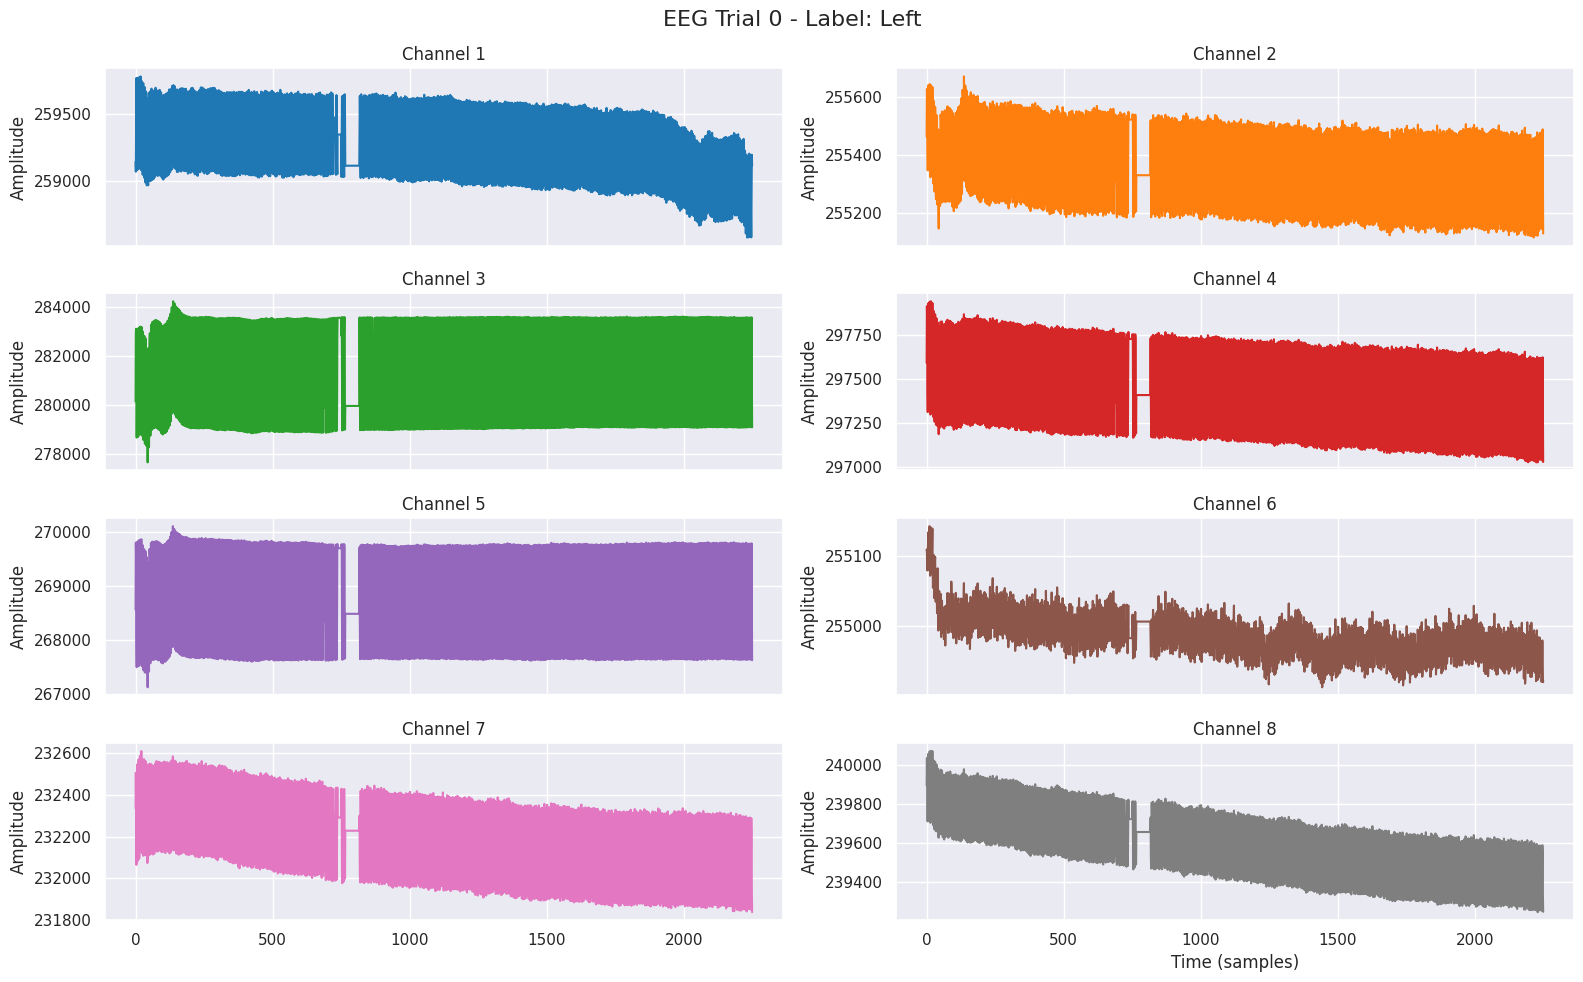

In [104]:
# trial to plot
trial = 0


fig, axes = plt.subplots(4, 2, figsize=(16, 10), sharex=True)
axes = axes.flatten()
time = np.arange(train_data.shape[2])

fig.suptitle(
    f"EEG Trial {trial} - Label: {revserse_label_mapping[str(train_labels[trial])]}",
    fontsize=16,
)
(train_labels[trial])
for ch in range(8):
    axes[ch].plot(time, train_data[trial, ch], color=plt.cm.tab10(ch))
    axes[ch].set_title(f"Channel {ch + 1}")
    axes[ch].set_ylabel("Amplitude")
    axes[ch].grid(True)

axes[-1].set_xlabel("Time (samples)")
plt.tight_layout()
plt.show()

#### Plotting a trial after the transformations:

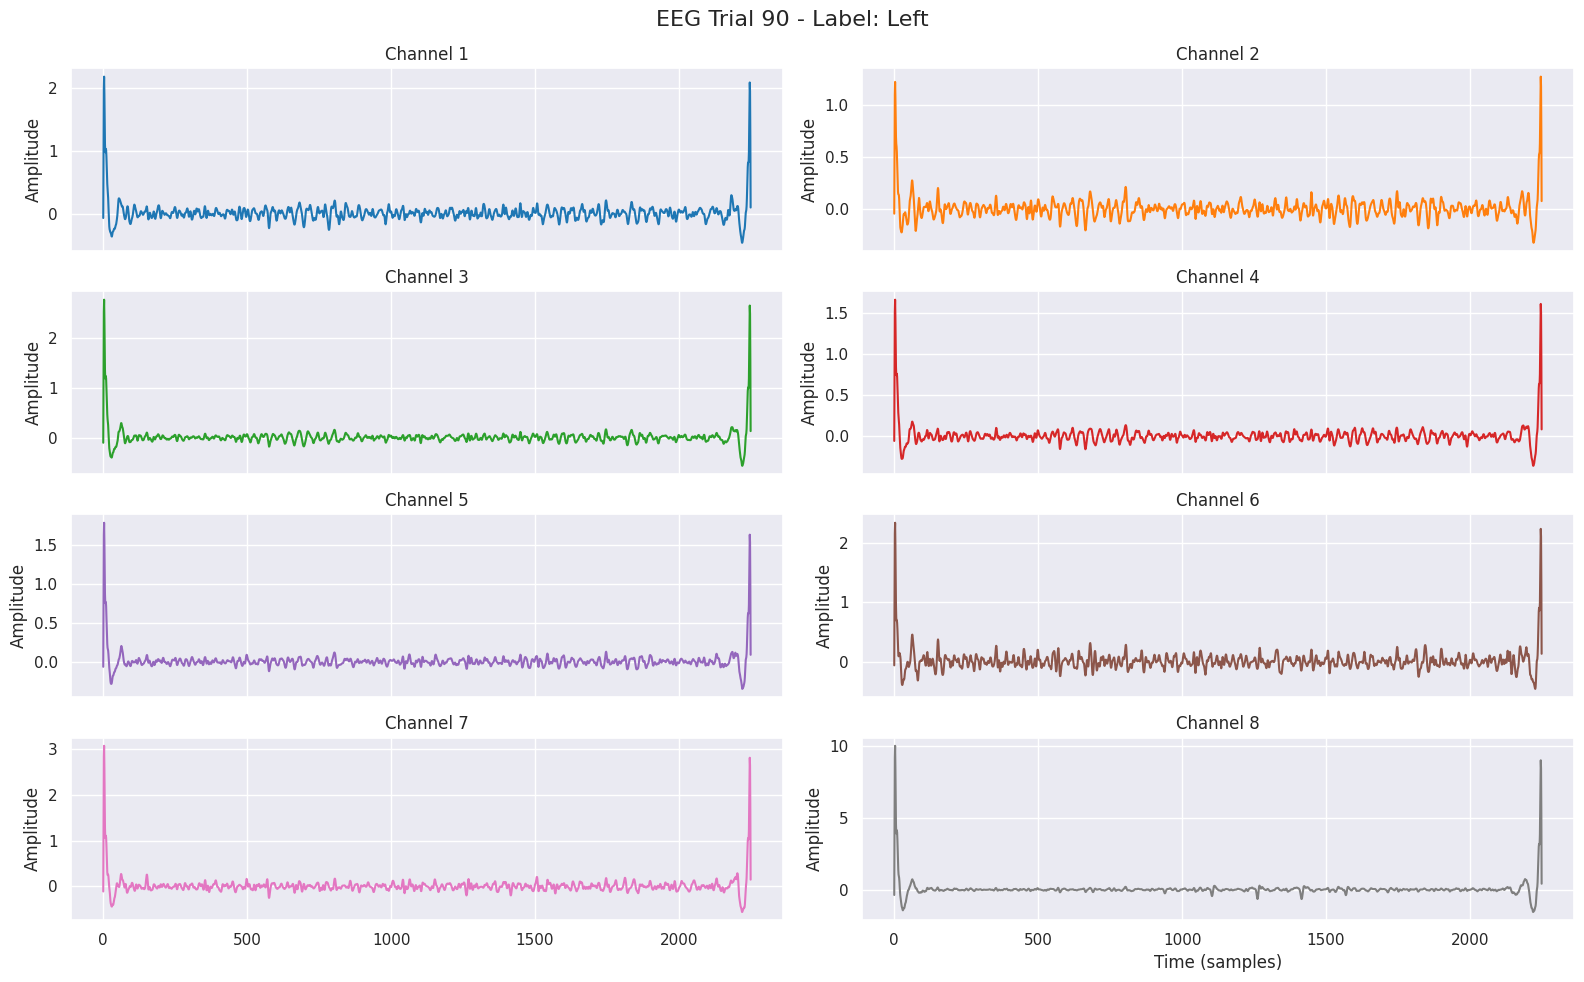

In [105]:
# trial to plot
trial = 90

fig, axes = plt.subplots(4, 2, figsize=(16, 10), sharex=True)
axes = axes.flatten()
time = np.arange(train_data_transformed.shape[3])

fig.suptitle(
    f"EEG Trial {trial} - Label: {revserse_label_mapping[str(train_labels_transformed[trial])]}",
    fontsize=16,
)
# The transformed data shape is (n_trials, 1, n_channels, n_timepoints)
# So we need to index as train_data_transformed[trial, 0, ch]
for ch in range(8):
    axes[ch].plot(time, train_data_transformed[trial, 0, ch], color=plt.cm.tab10(ch))
    axes[ch].set_title(f"Channel {ch + 1}")
    axes[ch].set_ylabel("Amplitude")
    axes[ch].grid(True)

axes[-1].set_xlabel("Time (samples)")
plt.tight_layout()
plt.show()

#### Plotting Aggregates before and after the transformation 

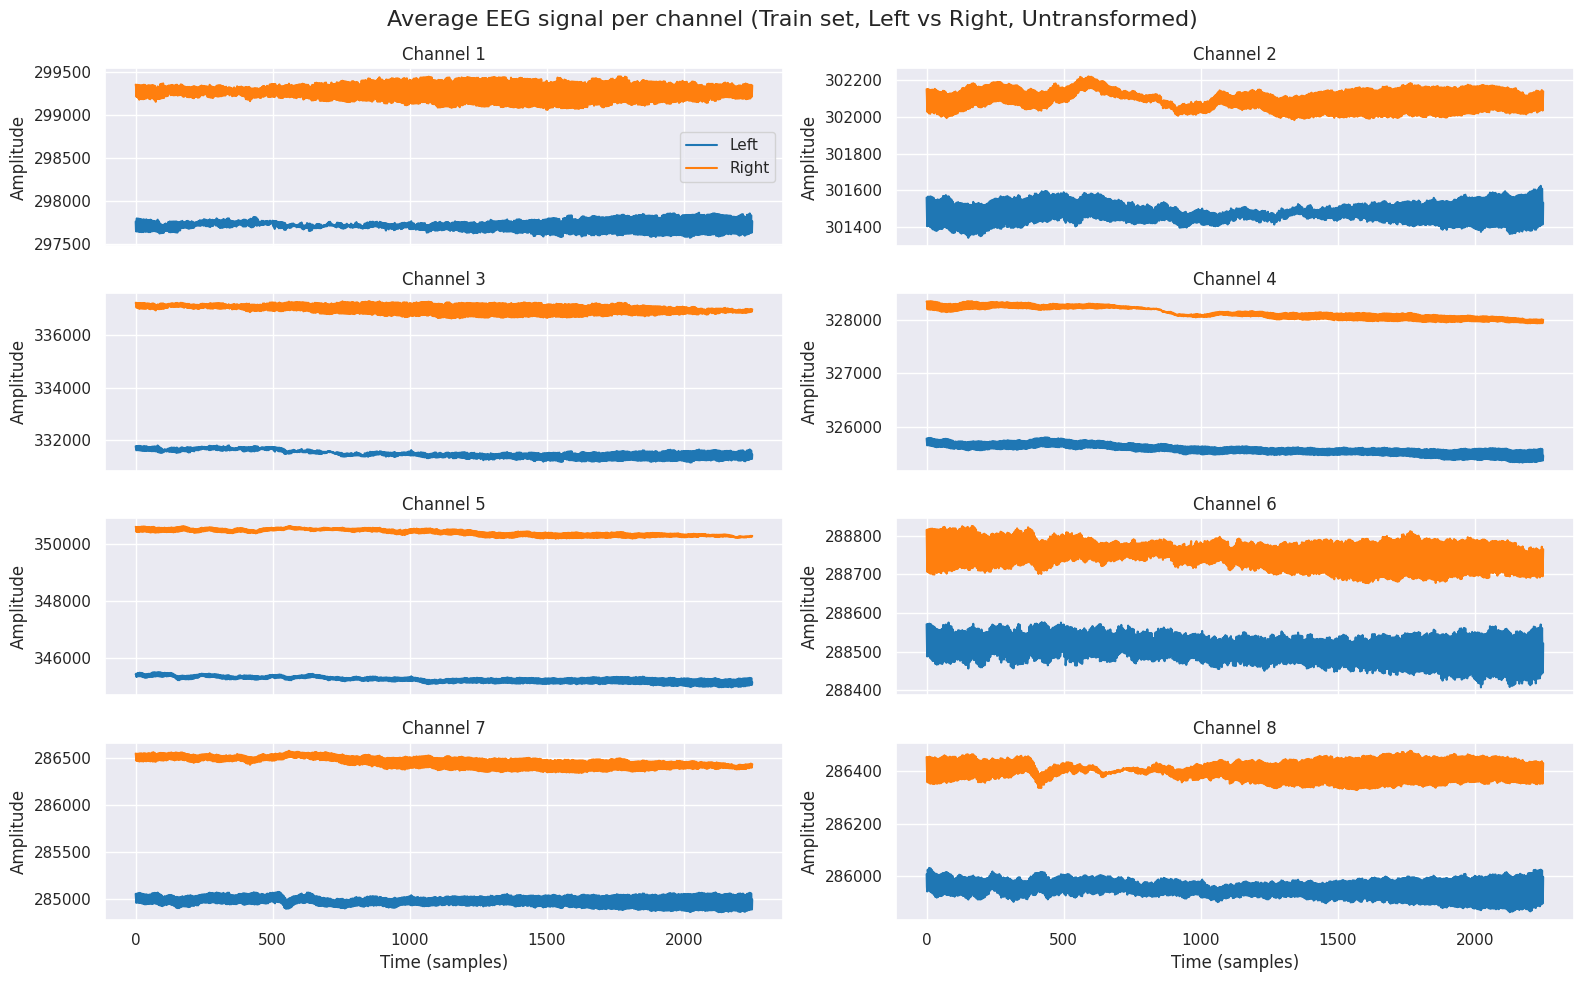

In [106]:
# Aggregate plot: average EEG signal per channel for Left and Right (untransformed data)
labels_to_plot = [0, 1]
label_names = [revserse_label_mapping[str(l)] for l in labels_to_plot]

fig, axes = plt.subplots(4, 2, figsize=(16, 10), sharex=True)
fig.suptitle(
    "Average EEG signal per channel (Train set, Left vs Right, Untransformed)",
    fontsize=16,
)
axes = axes.flatten()
time = np.arange(train_data.shape[2])

for ch in range(8):
    for label, color in zip(labels_to_plot, ["tab:blue", "tab:orange"]):
        mask = train_labels == label
        avg_signal = train_data[mask, ch].mean(axis=0)
        axes[ch].plot(time, avg_signal, label=label_names[label], color=color)
    axes[ch].set_title(f"Channel {ch + 1}")
    axes[ch].set_ylabel("Amplitude")
    axes[ch].grid(True)
    if ch == 0:
        axes[ch].legend()

axes[-1].set_xlabel("Time (samples)")
axes[-2].set_xlabel("Time (samples)")
plt.tight_layout()
plt.show()

This clear separation between averages of Right vs Left labels across channels is a big red flag and a sign of artifacts which have to be removed. 

In [107]:
from typing import List


def plot_with_transform(transform_list: List[str] = ["notch", "band", "crop"]):
    steps = []

    if "notch" in transform_list:
        steps.append(
            (
                "notch_filter",
                MNENotchFilter(
                    sfreq=processing_config.sfreq,
                    notch_freq=processing_config.notch_freq,
                ),
            )
        )
    if "band" in transform_list:
        steps.append(
            (
                "bandpass_filter",
                BandPassFilter(
                    sfreq=processing_config.sfreq,
                    low_freq=processing_config.bandpass_low,
                    high_freq=processing_config.bandpass_high,
                    order=processing_config.filter_order,
                ),
            )
        )
    if "crop" in transform_list:
        steps.append(
            (
                "temporal_crop",
                TemporalCrop(
                    tmin=processing_config.tmin,
                    tmax=processing_config.tmax,
                    sfreq=processing_config.sfreq,
                ),
            )
        )
    if "artifact" in transform_list:
        steps.append(
            (
                "artifact_removal",
                StatisticalArtifactRemoval(
                    z_threshold=processing_config.z_threshold, method="iqr"
                ),
            )
        )

    simple_pipeline = Pipeline(steps)
    transformed_train = simple_pipeline.fit_transform(train_data)

    # Aggregate plot: average EEG signal per channel for Left and Right (untransformed data)
    labels_to_plot = [0, 1]
    label_names = [revserse_label_mapping[str(l)] for l in labels_to_plot]

    fig, axes = plt.subplots(4, 2, figsize=(16, 10), sharex=True)
    fig.suptitle(
        f"Average EEG signal per channel (Train set, Left vs Right, Transformed) ({' '.join(transform_list)})",
        fontsize=16,
    )
    axes = axes.flatten()
    time = np.arange(transformed_train.shape[2])
    train_labels_copy = train_labels
    
    if "artifact" in transform_list:
        clean_indices = simple_pipeline.named_steps["artifact_removal"].clean_indices_
        train_labels_copy = train_labels_copy[clean_indices]

    for ch in range(8):
        for label, color in zip(labels_to_plot, ["tab:blue", "tab:orange"]):
            mask = train_labels_copy == label
            avg_signal = transformed_train[mask, ch].mean(axis=0)
            axes[ch].plot(time, avg_signal, label=label_names[label], color=color)
        axes[ch].set_title(f"{processing_config.ch_names[ch]}")
        axes[ch].set_ylabel("Amplitude")
        axes[ch].grid(True)
        if ch == 0:
            axes[ch].legend()

    axes[-1].set_xlabel("Time (samples)")
    axes[-2].set_xlabel("Time (samples)")
    plt.tight_layout()
    plt.show()

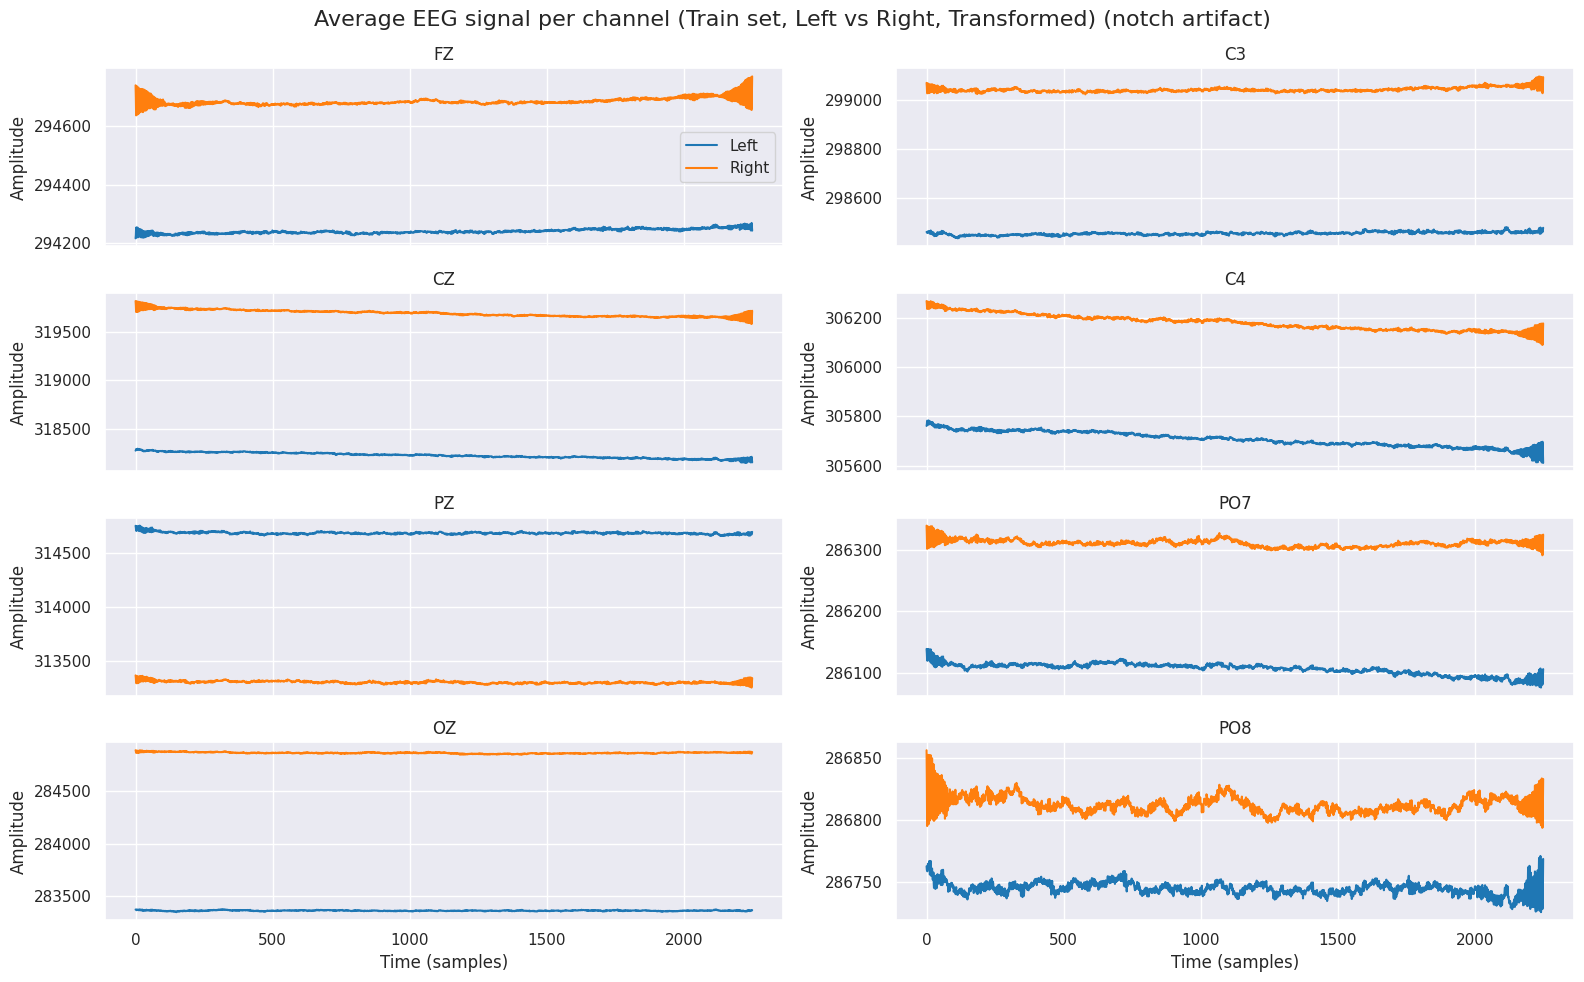

In [91]:
plot_with_transform(["notch", "artifact"])

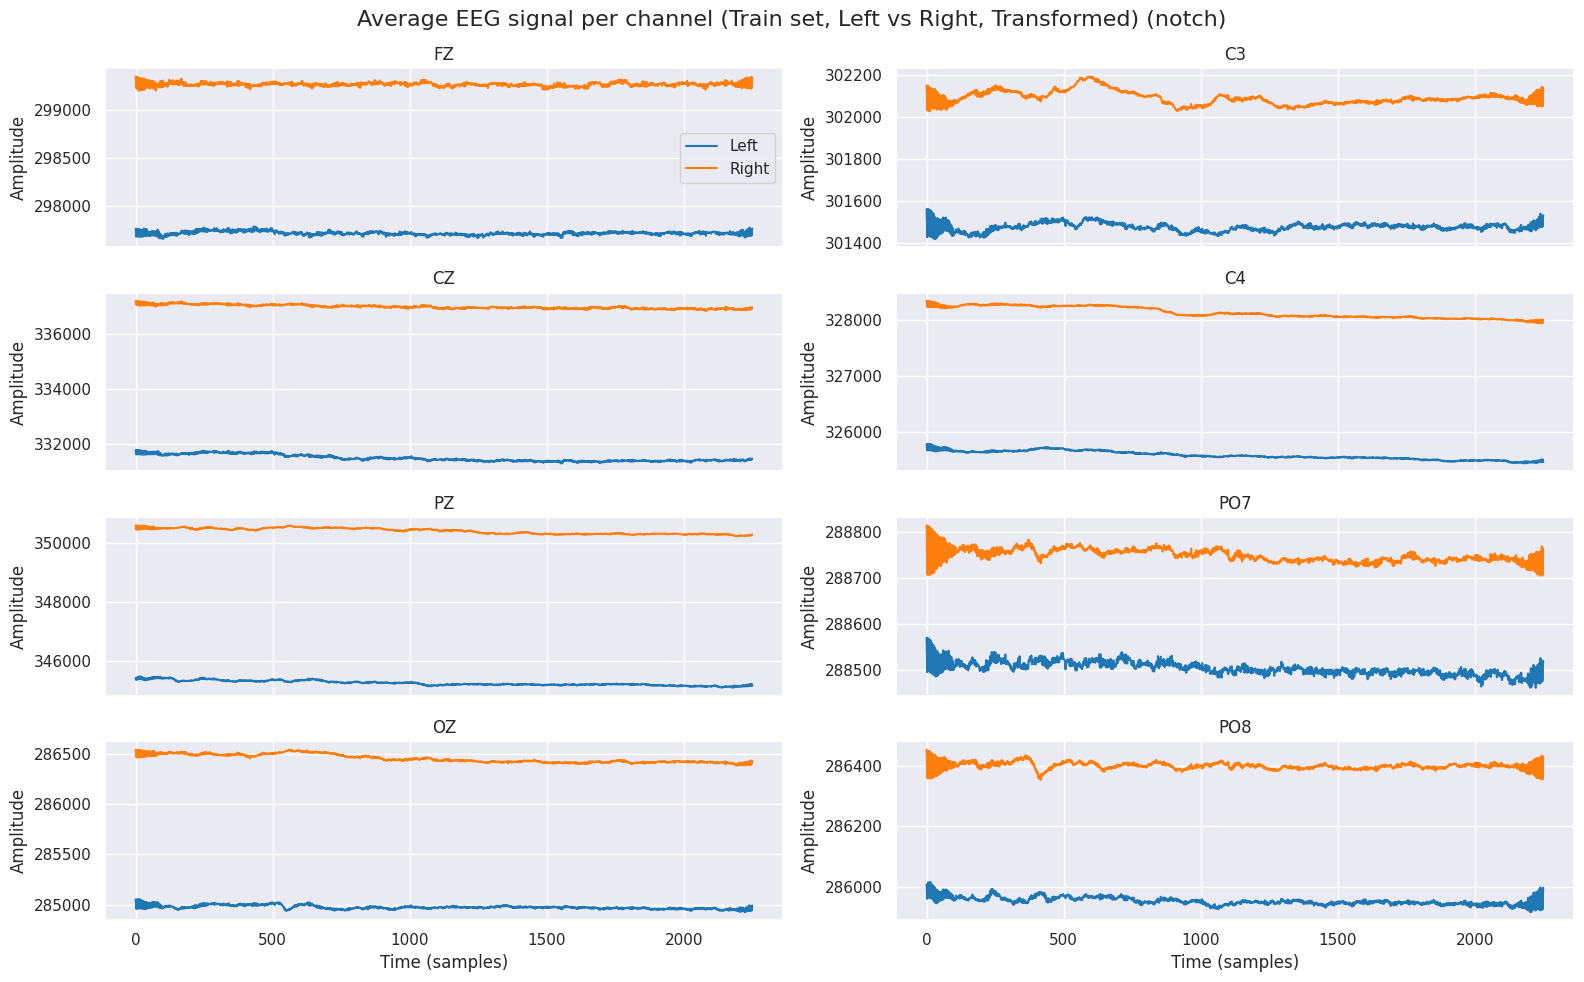

In [84]:
plot_with_transform(["notch"])

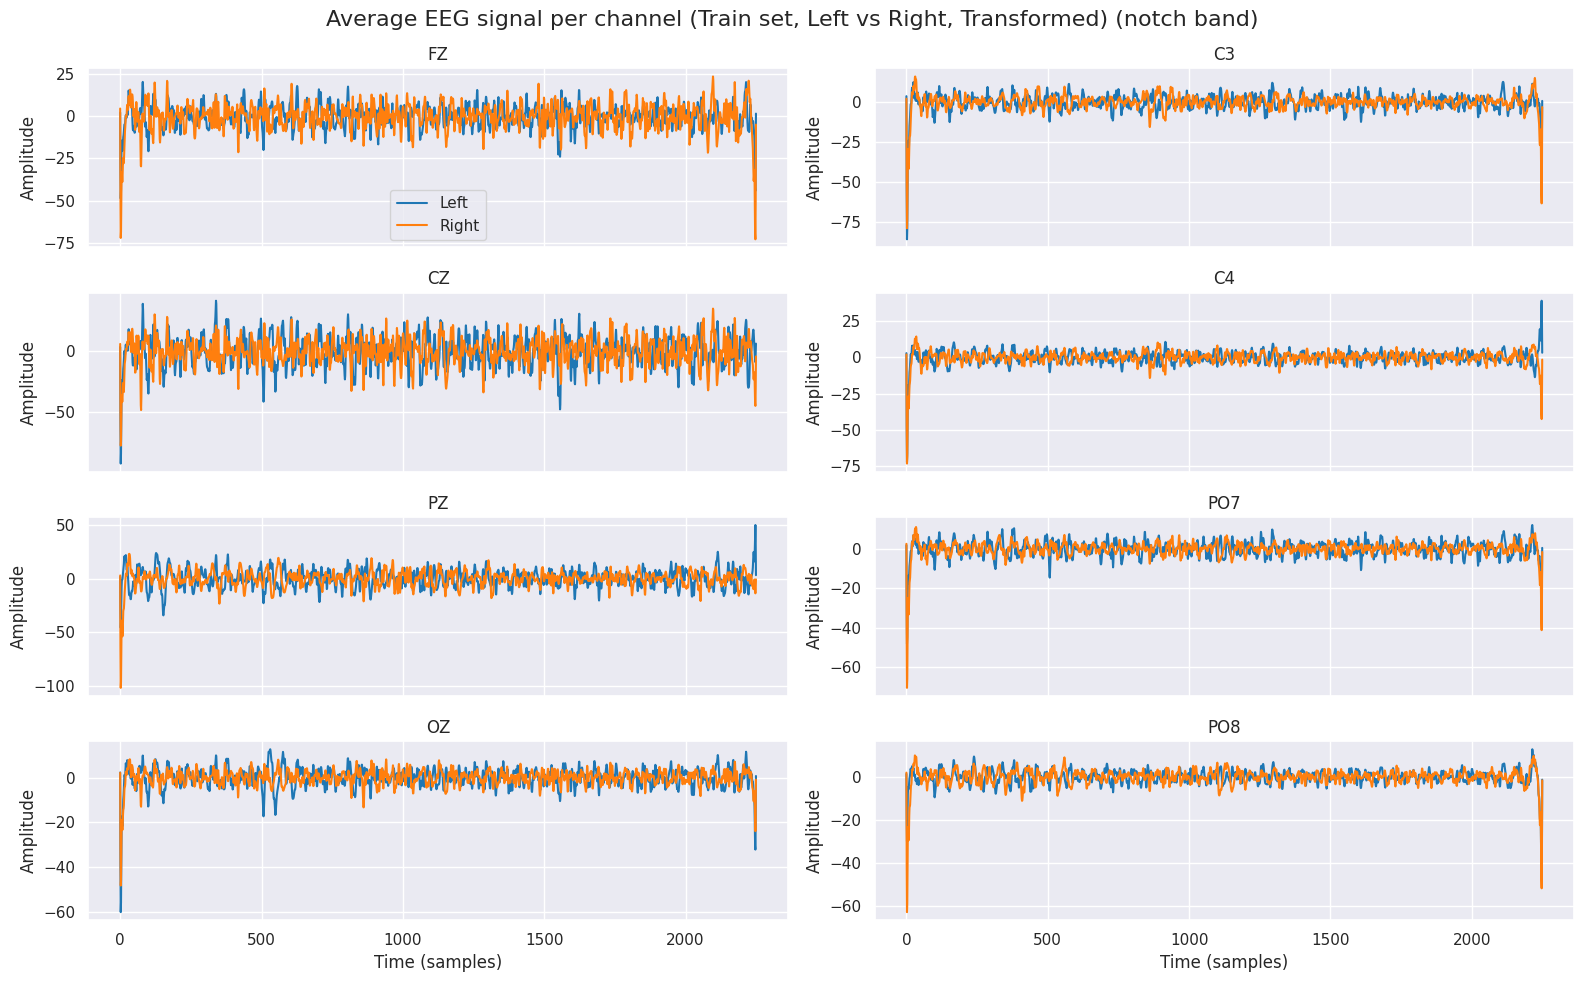

In [85]:
plot_with_transform(["notch", "band"])

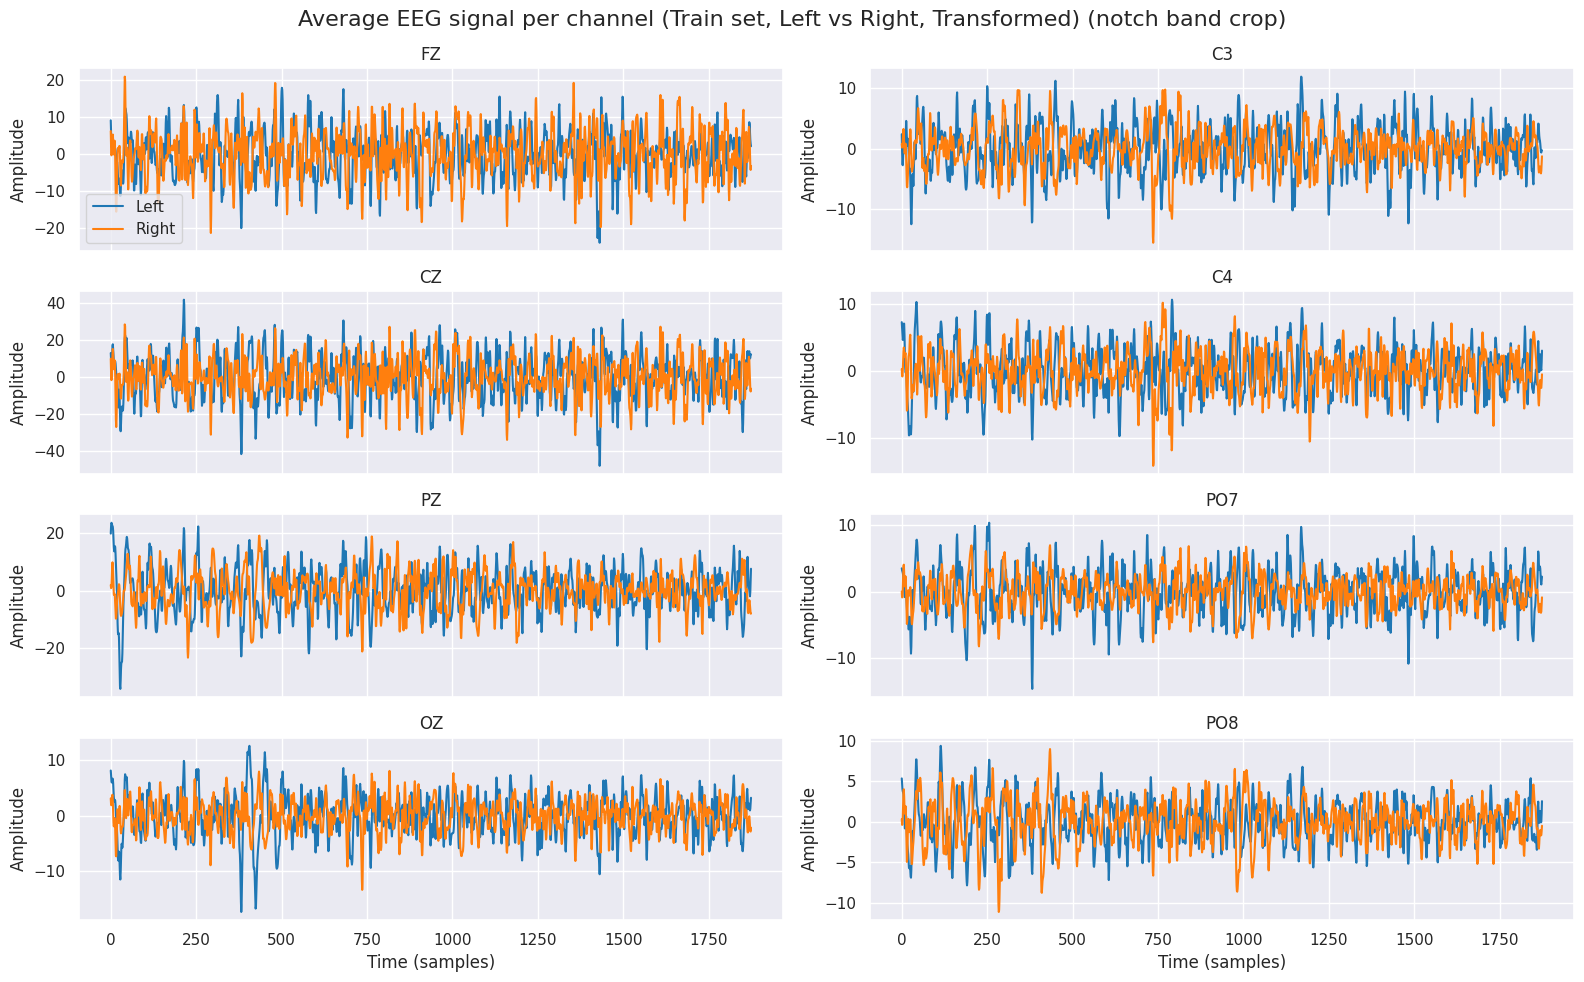

In [86]:
plot_with_transform(["notch", "band", "crop"])

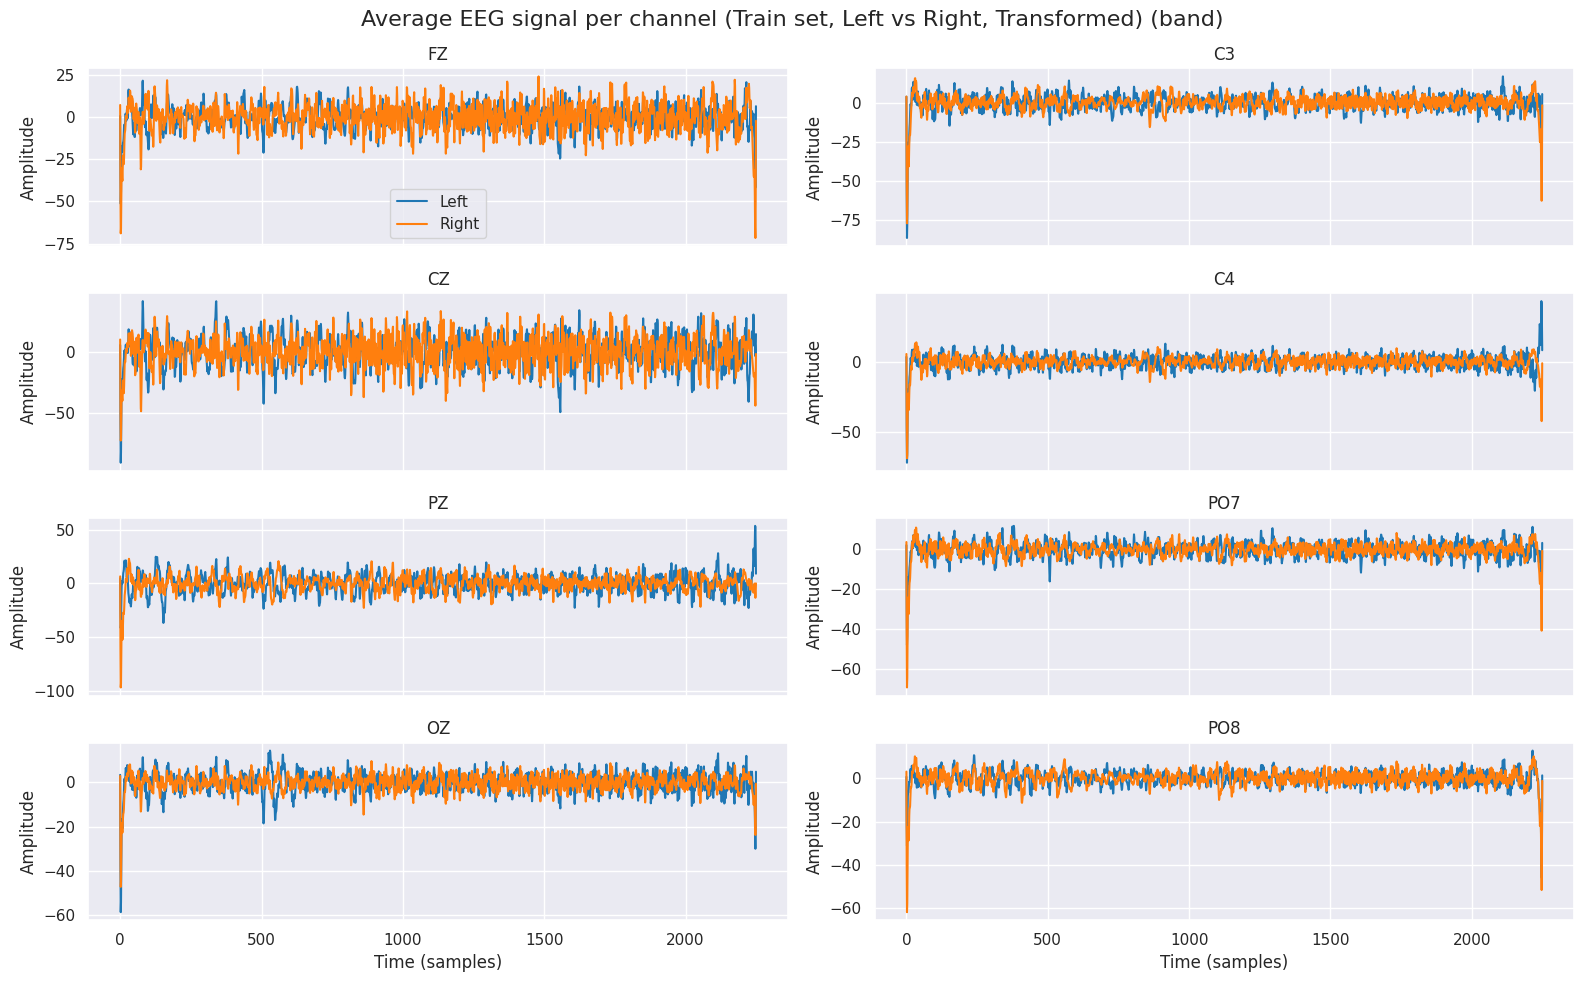

In [87]:
plot_with_transform(["band"])

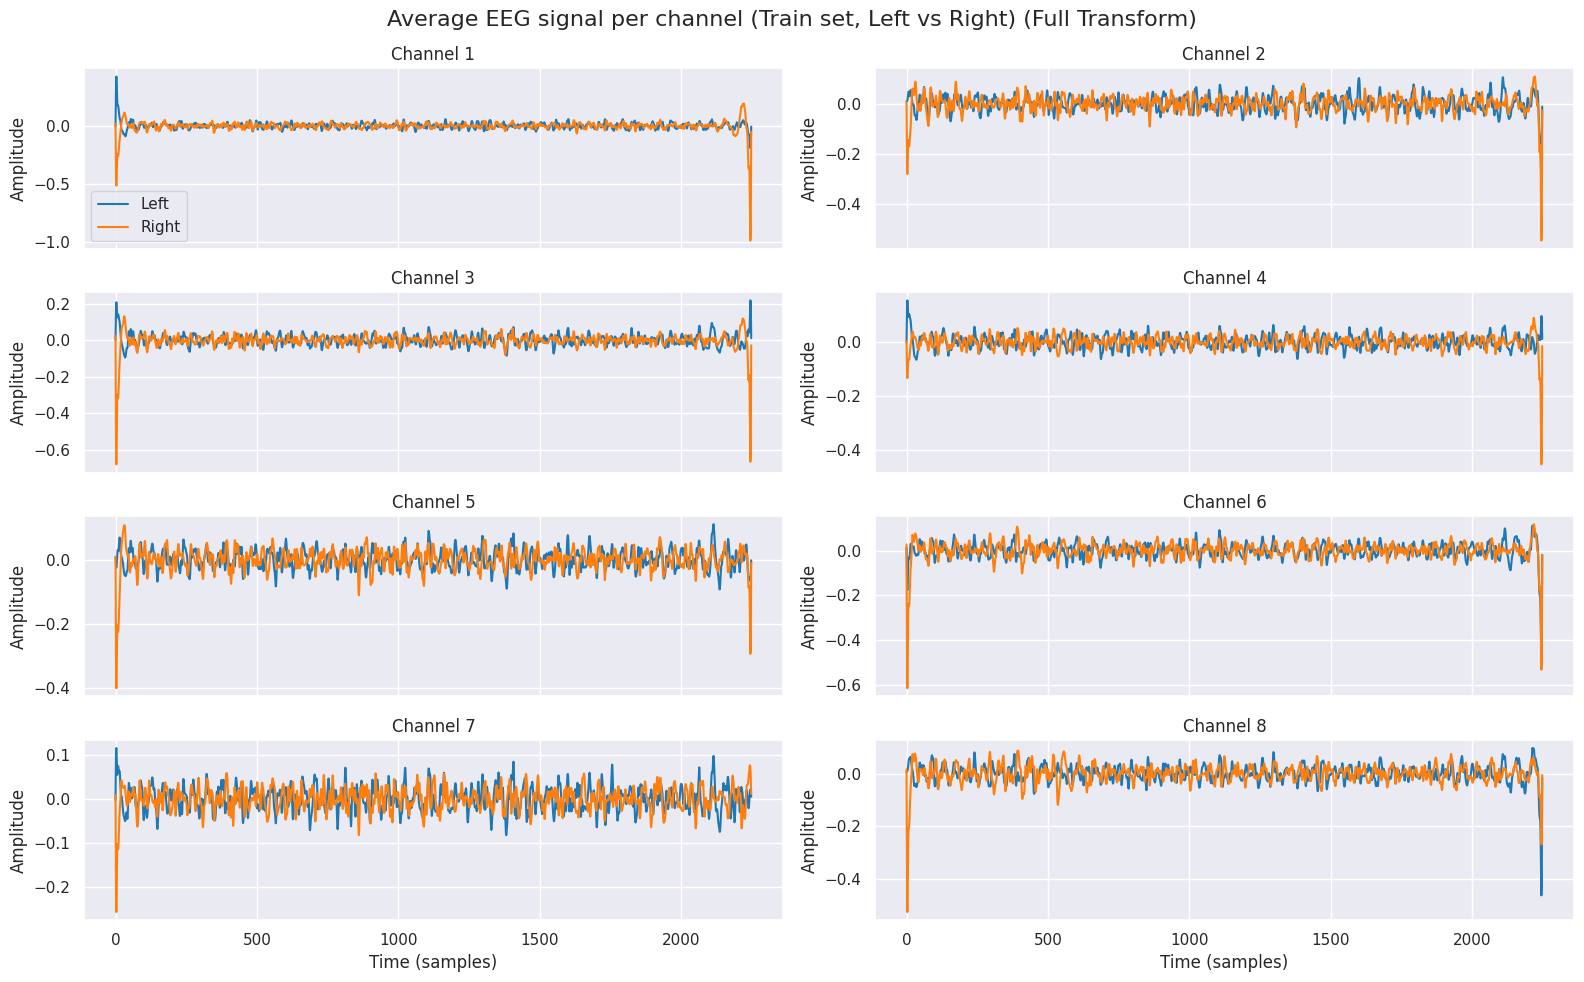

In [108]:
# Aggregate plot: average EEG signal per channel for Left and Right
labels_to_plot = [0, 1]
label_names = [revserse_label_mapping[str(l)] for l in labels_to_plot]

fig, axes = plt.subplots(4, 2, figsize=(16, 10), sharex=True)
fig.suptitle(
    "Average EEG signal per channel (Train set, Left vs Right) (Full Transform)",
    fontsize=16,
)
axes = axes.flatten()
time = np.arange(train_data_transformed.shape[3])

for ch in range(8):
    for label, color in zip(labels_to_plot, ["tab:blue", "tab:orange"]):
        mask = train_labels_transformed == label
        # train_data_transformed: (n_trials, 1, n_channels, n_timepoints)
        avg_signal = train_data_transformed[mask, 0, ch].mean(axis=0)
        axes[ch].plot(time, avg_signal, label=label_names[label], color=color)
    axes[ch].set_title(f"Channel {ch + 1}")
    axes[ch].set_ylabel("Amplitude")
    axes[ch].grid(True)
    if ch == 0:
        axes[ch].legend()

axes[-1].set_xlabel("Time (samples)")
axes[-2].set_xlabel("Time (samples)")
plt.tight_layout()
plt.show()

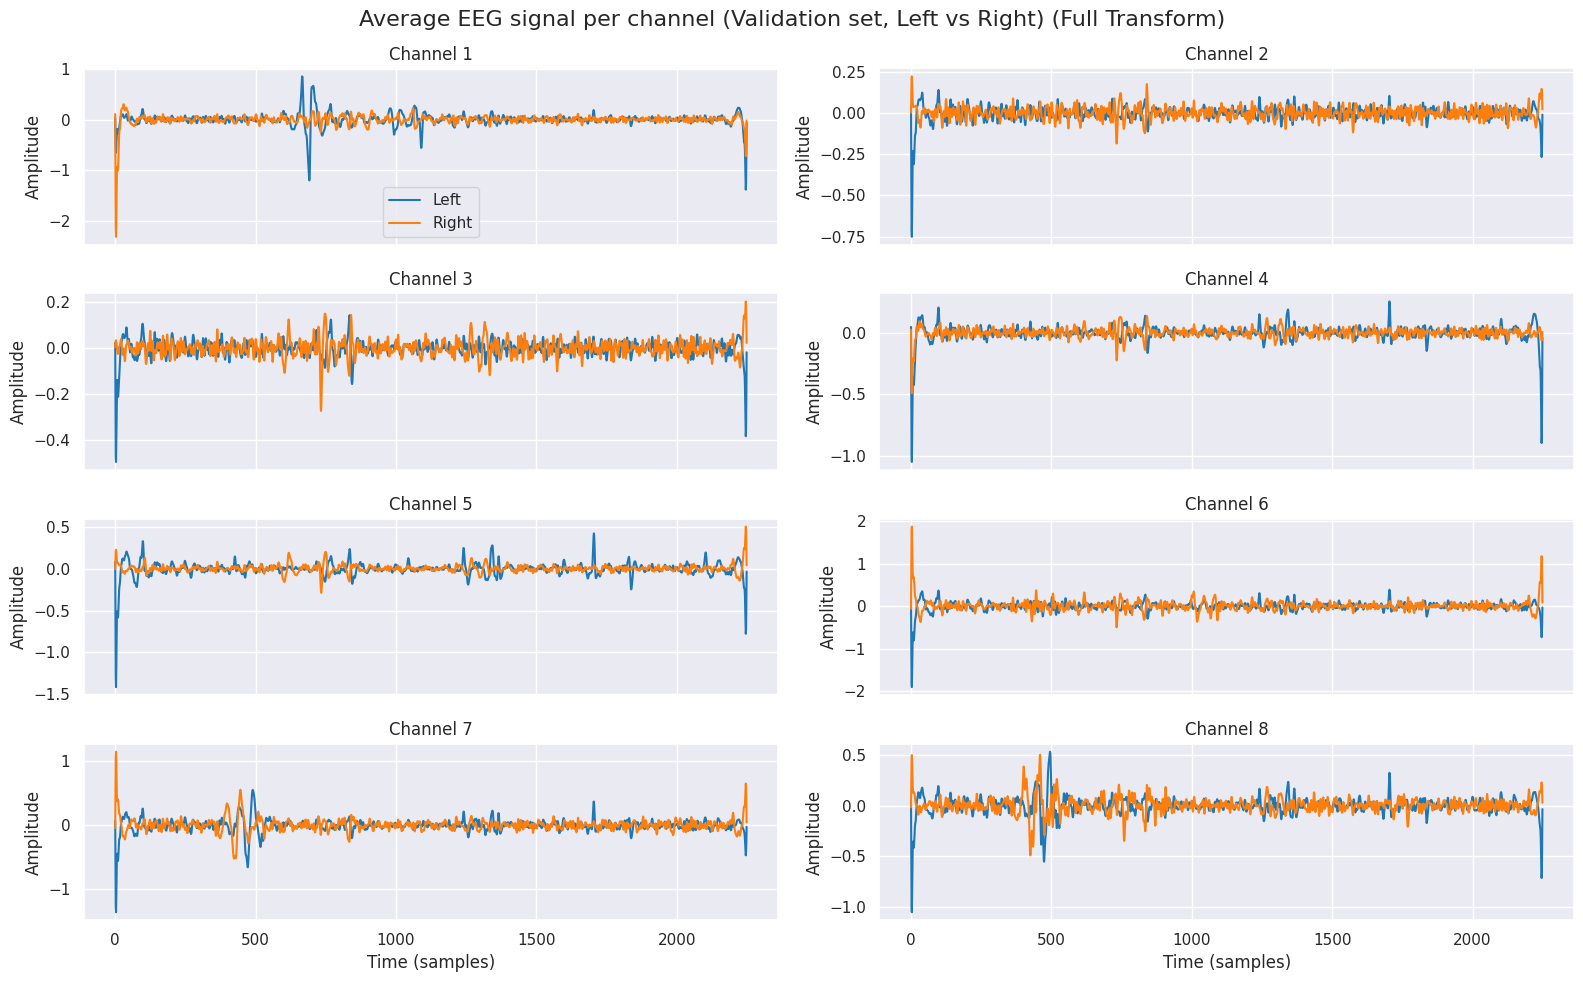

In [109]:
# --- Validation aggregate plot ---
# Aggregate plot: average EEG signal per channel for Left and Right
labels_to_plot = [0, 1]
label_names = [revserse_label_mapping[str(l)] for l in labels_to_plot]
fig, axes = plt.subplots(4, 2, figsize=(16, 10), sharex=True)
fig.suptitle(
    "Average EEG signal per channel (Validation set, Left vs Right) (Full Transform)",
    fontsize=16,
)
axes = axes.flatten()
time = np.arange(val_data_transformed.shape[3])

for ch in range(8):
    for label, color in zip(labels_to_plot, ["tab:blue", "tab:orange"]):
        mask = val_labels_transformed == label
        avg_signal = val_data_transformed[mask, 0, ch].mean(axis=0)
        axes[ch].plot(time, avg_signal, label=label_names[label], color=color)
    axes[ch].set_title(f"Channel {ch + 1}")
    axes[ch].set_ylabel("Amplitude")
    axes[ch].grid(True)
    if ch == 0:
        axes[ch].legend()

axes[-1].set_xlabel("Time (samples)")
axes[-2].set_xlabel("Time (samples)")
plt.tight_layout()
plt.show()

## Model Training

In [7]:
from bci_aic3.train import create_processed_data_loaders, setup_callbacks
from bci_aic3.config import load_model_config, load_training_config
from bci_aic3.paths import PROCESSED_DATA_DIR

In [8]:
train_loader, val_loader = create_processed_data_loaders(
    processed_data_dir=PROCESSED_DATA_DIR,
    task_type=task_type,
    batch_size=training_config.batch_size,
    num_workers=6,
)

In [11]:
from datetime import datetime
import os
import shutil
from pytorch_lightning import seed_everything

from bci_aic3.paths import MI_RUNS_DIR, SSVEP_RUNS_DIR
from bci_aic3.train import train_model
from bci_aic3.util import get_model_class, save_model

torch.set_float32_matmul_precision("medium")

# Code necessary to create reproducible runs
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
seed_everything(42, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)


task_type = "MI"

config_path = None
save_path = None
if task_type.upper() == "MI":
    config_path = MI_CONFIG_PATH
    save_path = MI_RUNS_DIR
elif task_type.upper() == "SSVEP":
    config_path = SSVEP_CONFIG_PATH
    save_path = SSVEP_RUNS_DIR
else:
    raise (
        ValueError(f"Invalid task_type: {task_type}.\nValid task_type (MI) or (SSVEP)")
    )

model_config = load_model_config(config_path)
training_config = load_training_config(config_path)

# model to use
model = get_model_class(model_config.name)
model_name = model.__name__

# Create a unique temporary directory first, using only the timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
temp_run_folder_name = f"{model_name}-{timestamp}-inprogress"
temp_run_save_dir = save_path / temp_run_folder_name

# Ensure directory and a subdirectory for checkpoints exist
checkpoints_subdir = temp_run_save_dir / "checkpoints"
os.makedirs(checkpoints_subdir, exist_ok=True)
print(f"Created temporary run directory: {temp_run_save_dir}")


Seed set to 42


Created temporary run directory: /home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress


In [12]:
# model = model(
#     num_electrodes=model_config.num_channels,
#     chunk_size=model_config.new_sequence_length,
#     num_classes=model_config.num_classes,
# )
from torcheeg.models import EEGNet, ATCNet

# model = EEGNet(
#     num_electrodes=model_config.num_channels,
#     chunk_size=model_config.new_sequence_length,
#     num_classes=model_config.num_classes,
#     F1=8,
#     D=1,     # Cannot use D=2 with F1=8
#     F2=8,    # F1 × D
#     kernel_1=187,
#     kernel_2=16,
#     dropout=0.3,
# )

model = ATCNet(
    num_electrodes=model_config.num_channels,
    chunk_size=model_config.new_sequence_length,
    num_classes=model_config.num_classes,
    num_windows=6,        
    tcn_kernel_size=4,    
    F1=4,                 
    D=2,
    conv_pool_size=7,
    tcn_depth=2,          
)

trainer, model = train_model(
    model=model,
    config_path=config_path,
    checkpoints_path=checkpoints_subdir,
    verbose=True,
)

f1_score = trainer.callback_metrics.get("val_f1")
if f1_score is None:
    # Fallback for early failure
    f1_score = 0.0

# Create the final directory name with f1 score
final_run_folder_name = f"{model_name}-f1-{f1_score:.4f}-{timestamp}"
final_save_dir = save_path / final_run_folder_name

# Rename the temporary directory to its final name
os.rename(temp_run_save_dir, final_save_dir)
print(f"Renamed run directory to: {final_save_dir}")

# Copy config file to new model directory
shutil.copy(config_path, final_save_dir / "config.yaml")
print(f"Saved config to {final_save_dir / 'config.yaml'}")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | ATCNet             | 93.6 K | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | train_f1       | MulticlassF1Score  | 0      | train
5 | val_f1         | MulticlassF1Score  | 0      | train
--------------------------------------------------------------
93.6 K    Trainable params
0         Non-trainable params
93.6 K    Total params
0.374     Total estimated model params size (MB)
112       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.679
Epoch 0, global step 58: 'val_f1' reached 0.35484 (best 0.35484), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.3548-epoch=00.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 116: 'val_f1' reached 0.37500 (best 0.37500), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.3750-epoch=01.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 174: 'val_f1' reached 0.35484 (best 0.37500), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.3548-epoch=02.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 232: 'val_f1' reached 0.43574 (best 0.43574), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.4357-epoch=03.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 290: 'val_f1' reached 0.64912 (best 0.64912), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.6491-epoch=04.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.673
Epoch 5, global step 348: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.669
Epoch 6, global step 406: 'val_f1' reached 0.52381 (best 0.64912), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.5238-epoch=06.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.658
Epoch 7, global step 464: 'val_f1' reached 0.52381 (best 0.64912), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.5238-epoch=07.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 522: 'val_f1' reached 0.56044 (best 0.64912), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.5604-epoch=08.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 580: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 638: 'val_f1' reached 0.53964 (best 0.64912), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.5396-epoch=10.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.655
Epoch 11, global step 696: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 754: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.654
Epoch 13, global step 812: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.650
Epoch 14, global step 870: 'val_f1' reached 0.64194 (best 0.64912), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.6419-epoch=14.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.636
Epoch 15, global step 928: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 986: 'val_f1' reached 0.62667 (best 0.64912), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.6267-epoch=16.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.635
Epoch 17, global step 1044: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.622
Epoch 18, global step 1102: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1160: 'val_f1' reached 0.64194 (best 0.64912), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.6419-epoch=19.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.621
Epoch 20, global step 1218: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1276: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1334: 'val_f1' reached 0.64286 (best 0.64912), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.6429-epoch=22.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1392: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.613
Epoch 24, global step 1450: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1508: 'val_f1' reached 0.68750 (best 0.68750), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.6875-epoch=25.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1566: 'val_f1' reached 0.64912 (best 0.68750), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.6491-epoch=26.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1624: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1682: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1740: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 1798: 'val_f1' reached 0.67033 (best 0.68750), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.6703-epoch=30.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.593
Epoch 31, global step 1856: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 1914: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 1972: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 2030: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 2088: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 2146: 'val_f1' reached 0.68750 (best 0.68750), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.6875-epoch=36.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 2204: 'val_f1' reached 0.68750 (best 0.68750), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.6875-epoch=37.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 2262: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 2320: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 2378: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.576
Epoch 41, global step 2436: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 2494: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.571
Epoch 43, global step 2552: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.563
Epoch 44, global step 2610: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 2668: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 2726: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 2784: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 2842: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 2900: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50, global step 2958: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51, global step 3016: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52, global step 3074: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53, global step 3132: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54, global step 3190: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55, global step 3248: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56, global step 3306: 'val_f1' reached 0.69697 (best 0.69697), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.6970-epoch=56.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57, global step 3364: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58, global step 3422: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59, global step 3480: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60, global step 3538: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61, global step 3596: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62, global step 3654: 'val_f1' reached 0.74937 (best 0.74937), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.7494-epoch=62.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63, global step 3712: 'val_f1' reached 0.69697 (best 0.74937), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.6970-epoch=63.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64, global step 3770: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65, global step 3828: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66, global step 3886: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67, global step 3944: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68, global step 4002: 'val_f1' reached 0.74937 (best 0.74937), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.7494-epoch=68.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69, global step 4060: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70, global step 4118: 'val_f1' reached 0.74937 (best 0.74937), saving model to '/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250628_062105-inprogress/checkpoints/atcnet-mi-best-f1-val_f1=0.7494-epoch=70.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71, global step 4176: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72, global step 4234: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73, global step 4292: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74, global step 4350: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75, global step 4408: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76, global step 4466: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77, global step 4524: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78, global step 4582: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79, global step 4640: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80, global step 4698: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81, global step 4756: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82, global step 4814: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83, global step 4872: 'val_f1' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 40 records. Best score: 0.563. Signaling Trainer to stop.
Epoch 84, global step 4930: 'val_f1' was not in top 3


Renamed run directory to: /home/Crim/AIC3/bci_aic3/run/MI/ATCNet-f1-0.5960-20250628_062105
Saved config to /home/Crim/AIC3/bci_aic3/run/MI/ATCNet-f1-0.5960-20250628_062105/config.yaml


In [13]:
save_model(model=model, save_path=final_save_dir / "weights.pt")
print(f"Saved config to {final_save_dir / 'weights.pt'}")

Saving model weights to /home/Crim/AIC3/bci_aic3/run/MI/ATCNet-f1-0.5960-20250628_062105/weights.pt...
Model weights saved successfully.
Saved config to /home/Crim/AIC3/bci_aic3/run/MI/ATCNet-f1-0.5960-20250628_062105/weights.pt
